In [1]:
import sys
sys.path.insert(0, r'../../quetzal/')
import syspy

import geopandas as gpd
import pandas as pd
ipath = r'inputs/'

In [2]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (10, 10)

## Nearest neighbor

In [3]:
nodes = gpd.read_file(ipath + r'nodes.geojson')
clusters = gpd.read_file(ipath + r'clusters.geojson')

In [4]:
from syspy.syspy_utils import neighbors

In [5]:
neighbors.nearest(nodes, clusters)

,ix_one,index_nn,ix_many,distance,rank
0,0,32,32,0.000000,0
1,1,504,504,31.045714,0
424,424,504,504,31.045714,0
2,2,56,56,21.076526,0
720,720,56,56,21.076526,0
...,...,...,...,...,...
1022,1022,313,313,23.121956,0
1027,1027,313,313,23.121956,0
1026,1026,479,479,53.094864,0
1030,1030,479,479,53.094864,0


In [6]:
nodes['nearest_id'] = neighbors.nearest(nodes, clusters).set_index('ix_one')['ix_many']

<font color='#D22328'>
# Exercice
</font>

Créer un GeoDataFrame nearest_link, contenant les colonnes:
- node_id
- cluster_id
- geometry (LineString entre un node et son plus proche voisin)

In [7]:
clusters

,cluster,geometry
0,0,POINT (427539.75469 6708052.25593)
1,1,POINT (434061.38414 6712720.73978)
2,2,POINT (429087.01483 6717766.14761)
3,3,POINT (429336.00240 6714572.57237)
4,4,POINT (435566.62057 6717261.27509)
...,...,...
507,507,POINT (433257.59534 6711862.15096)
508,508,POINT (431768.81612 6711225.46558)
509,509,POINT (429902.36706 6717933.84592)
510,510,POINT (426827.84497 6712983.56661)


In [10]:
merged = nodes.merge(clusters, left_on='nearest_id', right_on='cluster')

<AxesSubplot: >

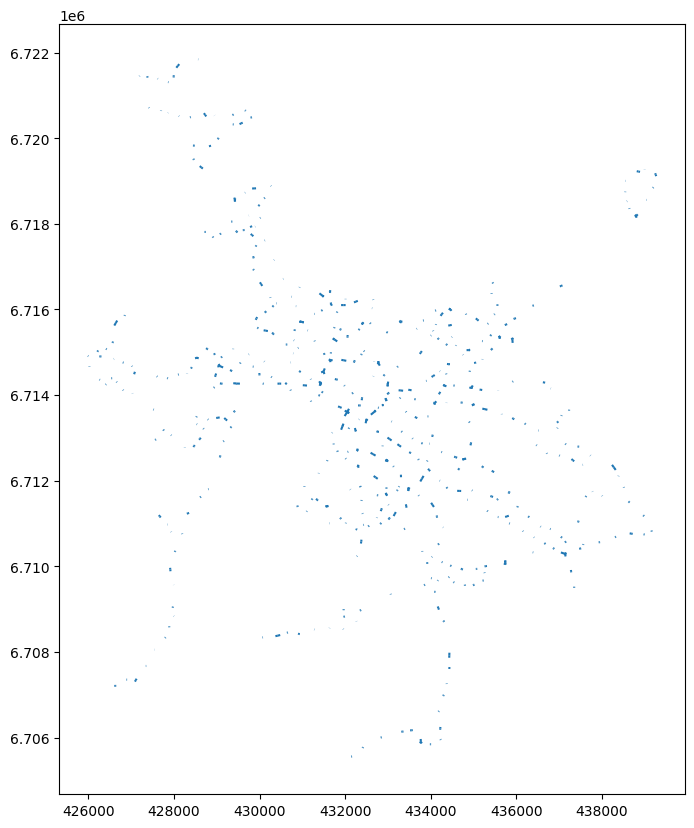

In [11]:
from shapely.geometry import LineString
def row_to_line(row):
    # row = merged.iloc[0]
    return LineString([row['geometry_x'], row['geometry_y']])

merged['geometry'] = merged.apply(row_to_line, axis=1)

gpd.GeoDataFrame(merged).plot()

In [12]:
df = neighbors.nearest(nodes, clusters)
node_geoms = nodes['geometry'].to_dict()
cluster_geoms = clusters['geometry'].to_dict()
df['geometry'] = df.apply(
    lambda x: LineString(
        (
            node_geoms[x['ix_one']],
            cluster_geoms[x['ix_many']]
        )
    ),
    axis=1
)
gpd.GeoDataFrame(df).to_file(r'inputs/nearest_link_shp.geojson')

## Desire lines

In [13]:
zones = gpd.read_file(ipath + 'zones_neighbors.geojson').set_index('zone_id')
ods = pd.read_csv(ipath + r'ods.csv', index_col=0)

In [14]:
neighborhood = neighbors.Neighborhood(
    zones.to_crs(epsg=4236), # only works in lat lon
    ods,
    ['volume']
)

FloatProgress(value=0.0, max=8.0)

neighborhood_dataframe: 100%|██████████| 370/370 [00:02<00:00, 143.47it/s]


In [15]:
od_geoms = neighborhood.export(
    'volume',
    affected=False,
)

No projection defined --> considered as EPSG:4326
can only map affected volumes with arg : od_geometry=False


In [16]:
from shapely.geometry import LineString

od_geoms['geometry'] = od_geoms.apply(
    lambda x: LineString(
        [
            (x['longitude_origin'], x['latitude_origin']),
            (x['longitude_destination'], x['latitude_destination'])
        ]
    ), 
    1
)

od_geoms = gpd.GeoDataFrame(od_geoms)[
    ['origin', 'destination', 'volume',
    'geometry', 'label', 'color', 'width']
]
od_geoms.to_file(
    ipath + r'desire_lines/non_affected_ods.geojson', driver='GeoJSON'
)

In [17]:
desire_lines = neighborhood.export(
    'volume',
    affected=True,
)
desire_lines = gpd.GeoDataFrame(desire_lines)[
    ['origin', 'destination', 'volume', 'volume_transit',
    'geometry', 'label', 'color', 'width']
]
desire_lines.to_file(
    ipath + r'desire_lines/affected_ods.geojson', driver='GeoJSON'
)

No projection defined --> considered as EPSG:4326


# classified desire lines

In [18]:
from syspy.spatial import spatial
cluster_geoms, cluster_ids = spatial.zone_clusters(
    zones, n_clusters=3
)
zones['cluster'] = cluster_ids

<AxesSubplot: >

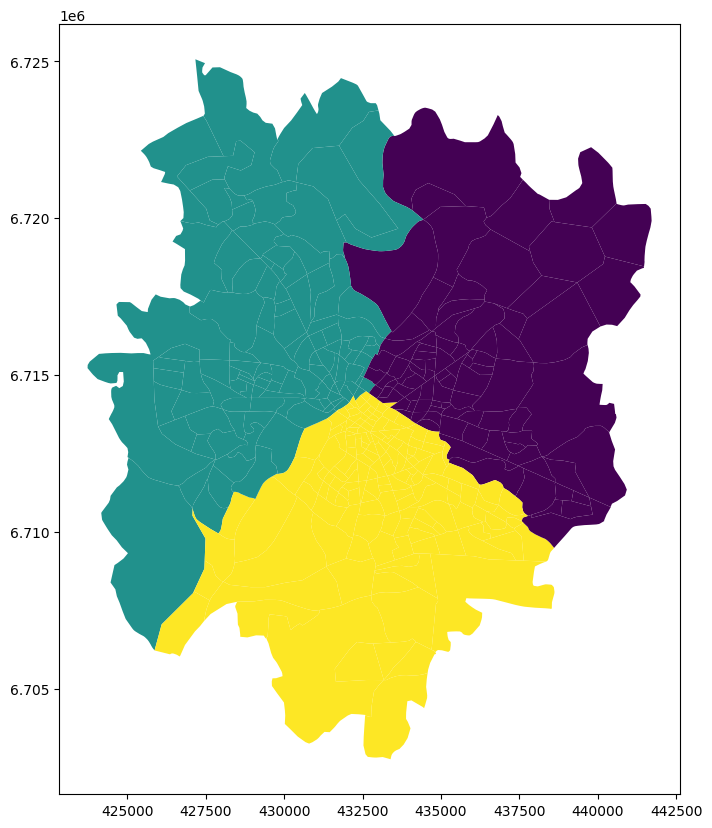

In [19]:
zones.plot('cluster')

In [20]:
neighbors.zones_classified_neighborhood(
    zones, ods, ipath + r'desire_lines/macro/', 'cluster', volume_col='volume'
)


2


FloatProgress(value=0.0, max=8.0)

neighborhood_dataframe: 100%|██████████| 370/370 [00:02<00:00, 160.87it/s]


0


FloatProgress(value=0.0, max=8.0)

neighborhood_dataframe: 100%|██████████| 370/370 [00:02<00:00, 161.15it/s]


1


FloatProgress(value=0.0, max=8.0)

neighborhood_dataframe: 100%|██████████| 370/370 [00:02<00:00, 162.42it/s]
3it [00:00,  4.26it/s]


In [21]:
# truc cassé à réparer ici